# Diet and Health
Updated March 13, 2017

Stephen Klosterman, steve.klosterman@gmail.com

People say "you are what you eat."  In this notebook, I examine how conventional wisdom stands up to data:  does our diet determine our health outcomes?  To characterize world diets, I use data on consumption of over 100 food items on a per country basis, from the United Nations Food and Agriculture Organization.  For health outcomes, I use non-communicable disease data from the World Health Organization.  After exploring and cleaning the data, I use statistical methods to examine whether world diets can explain variation in mortality rates by country, and which food items are linked to disease.

This notebook is a work in progress and will be updated.  Currently there is:

1. Exploratory data analysis
 - Mapping
 - Cleaning
 - Database merging
2. Data analysis
 - Linear and lasso regression

Coming soon:  principal component analysis

In [84]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import itertools
%matplotlib inline

# Cardiovascular disease data
This data comes from the World Health Organization (WHO) (http://www.who.int/gho/database/en/).  Cardiovascular disease is an example of a non-communicable disease, meaning it is not contagious, although genetic factors may be involved.  Lifestyle choices such as diet and exercise are thought to be important factors in whether someone develops cardiovascular disease.  I load the disease data and separate the WHO 2000 survey as training data and 2012 as testing data.

In [85]:
#Load cardiovascular disease data
cardio_file = '../data/data.csv'
cardio_data = pd.read_csv(cardio_file)

#Select relevant field
cardio_data_all = cardio_data.drop(['Age-standardized mortality rate by cause (per 100 000 population).1', \
                  'Age-standardized mortality rate by cause (per 100 000 population).2'], axis=1)

cardio_years = ['2000', '2012']
cardio_data = []
#Create list of dataframes in 'cardio_data' according to 'cardio_years'
for i in np.arange(len(years)):
    #Isolate data from year of interest
    cardio_data.append(cardio_data_all[cardio_data_all['Unnamed: 1'].isin([years[i]])])
    #Drop year column
    cardio_data[i] = cardio_data[i].drop(['Unnamed: 1'], axis=1)
    #Rename country column
    cardio_data[i] = cardio_data[i].rename(columns={'Unnamed: 0' : 'Country'})
    
#Show 2012 data
cardio_data[1].head()

Country  \
2   Afghanistan   
4       Albania   
6       Algeria   
8        Angola   
10    Argentina   

   Age-standardized mortality rate by cause (per 100 000 population)  
2                                               511.5                 
4                                               436.2                 
6                                               396.6                 
8                                               374.6                 
10                                              191.7

## Mapping
Here I create a generic mapping function that will create a world map of something that varies by country, then use the function to visualize the cardiovascular disease data.

In [86]:
#Mapping function 'map_quantity'
#Inputs
#country_vector:  List of country names (strings)
#quantity_vector:  Corresponding numerical array of quantities
#title:  Title for colorbar
def map_quantity(country_vector, quantity_vector, title):
    #Lists of uncommon country names and their replacements
    map_names_need_changed = [
    'Bolivia',
    "C�te d'Ivoire",
    'Republic of Congo',
    'United Kingdom',
    'The Gambia',
    'Iran',
    'Lao PDR',
    'Macedonia',
    'Dem. Rep. Korea',
    'Syria',
    'Tanzania',
    'United States',
    'Venezuela',
    'Vietnam']
    countries_to_replace = [
    'Bolivia (Plurinational State of)',
    "Cote d'Ivoire",
    'Democratic Republic of the Congo',
    'United Kingdom of Great Britain and Northern Ireland',
    'Gambia',
    'Iran (Islamic Republic of)',
    "Lao People's Democratic Republic",
    'The former Yugoslav republic of Macedonia',
    "Democratic People's Republic of Korea",
    'Syrian Arab Republic',
    'United Republic of Tanzania',
    'United States of America',
    'Venezuela (Bolivarian Republic of)',
    'Viet Nam']

    #Basic stats on data
    min_quant = min(quantity_vector)
    max_quant = max(quantity_vector)
    #Set up map elements and axes
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m',
                                            category='cultural', name=shapename)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_axes([0.05, 0.15, 0.9, 0.8], projection=ccrs.Robinson())
    ax2 = fig.add_axes([0.05, 0.05, 0.9, 0.07])
    #Loop through countries in map database
    for country in shpreader.Reader(countries_shp).records():
        this_country_name = country.attributes['name_long']
        #Change name if necessary
        if this_country_name in map_names_need_changed:
                this_country_name = countries_to_replace[map_names_need_changed.index(this_country_name)]
        #If map country is in list of quantities, assign color based on quantity and map it
        if this_country_name in country_vector:
            #Get quantity for this country
            this_quantity = quantity_vector[country_vector.index(this_country_name)]
            #Scale quantity on [0, 1]
            scaled_quant = (this_quantity - min_quant)/(max_quant - min_quant)
            #Get scaled color for map
            this_color = plt.cm.jet(int(round(scaled_quant*256.)))
            #Plot country with this color
            ax1.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=this_color)
        else:
            #Plot country in gray
            ax1.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=np.array([(0.5, 0.5, 0.5)]))
            #And print the country to know missing countries
            #print this_country_name

    #Create plot
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=min_quant, vmax=max_quant)
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    font_size = 18
    cb.set_label(title,size=18)
    cb.ax.tick_params(labelsize=font_size)
    plt.show()
    return None

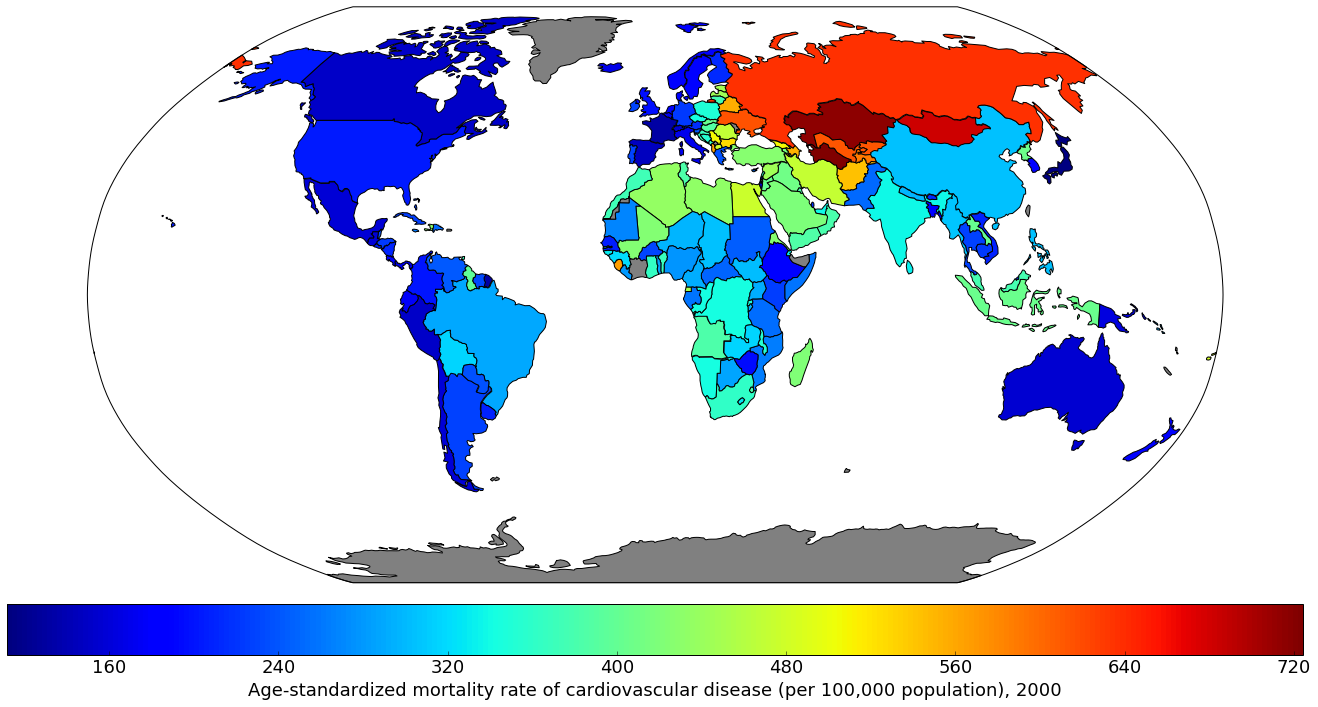

In [87]:
#Select 0 for 2000 results, 1 for 2012
map_index = 0
map_quantity(cardio_data[map_index]['Country'].values.tolist(),
             cardio_data[map_index]['Age-standardized mortality rate by cause (per 100 000 population)'].values.astype('float'),
            'Age-standardized mortality rate of cardiovascular disease (per 100,000 population), ' + cardio_years[map_index])

Northern Central Asia, Russia, and parts of Eastern Europe seem to have the highest incidences.  The Middle East and much of Africa have moderately high but variable rates, while Western Europe, the Americas, Australia, and Eastern Asian countries have relatively low rates of cardiovascular disease.

# Crop data
Data on food consumption is available from the United Nations Food and Agriculture Organization (FAO) (http://www.fao.org/faostat/en/#home).  Non-animal products, here called crops, are available separately from animal products.  I load the data, perform some cleaning, and create a subset from the 11 years prior to and including 2000, the year in which I have disease data for model training, with a similar approach for testing data (modeling 2012 disease data using food consumption data from 2002-2012).  This represents an assumption that a country's disease mortality rate in a given year is due to the national diet over the last decade or so.  Finally, I list all crop items in the data set.

In [88]:
#Read in crops data for checking row number
crop_file = '../data/1caaffac-d01c-4d02-8735-404d3089b47e.csv'
crop_data = pd.read_csv(crop_file)

In [89]:
crop_data.head()

﻿Domain Code                                  Domain  AreaCode AreaName  \
0           CC  Food Supply - Crops Primary Equivalent         1  Armenia   
1           CC  Food Supply - Crops Primary Equivalent         1  Armenia   
2           CC  Food Supply - Crops Primary Equivalent         1  Armenia   
3           CC  Food Supply - Crops Primary Equivalent         1  Armenia   
4           CC  Food Supply - Crops Primary Equivalent         1  Armenia   

   ElementCode                    ElementName  ItemCode    ItemName  Year  \
0          511  Total Population - Both sexes      2501  Population  1992   
1          511  Total Population - Both sexes      2501  Population  1993   
2          511  Total Population - Both sexes      2501  Population  1994   
3          511  Total Population - Both sexes      2501  Population  1995   
4          511  Total Population - Both sexes      2501  Population  1996   

   Value Flag          FlagD  
0   3449  NaN  Official data  
1   3370  NaN  Official data  
2   3290  NaN  Official data  
3   3223  NaN  Official data  
4   3173  NaN  Official data

In [90]:
#Get food item names
#ItemNames
crop_items = crop_data.ItemName.unique()
#Get rid of "population" and "nan"
crop_items = crop_items[1:-1]
#Get rid of Grand Total
crop_items = crop_items[np.not_equal(crop_items, 'Grand Total')]
print crop_items

#Get "food supply" for the requested range of years.  The FAO calculates food supply as production minus exports
#plus imports, so this is a stand-in for consumption.
combined_mask = []
crop_subset = []
crop_year_range = [[1990, 2000], [2002, 2012]]
for i in np.arange(len(crop_year_range)):
    combined_mask.append( crop_data.ItemName.isin(crop_items) & \
        crop_data.ElementName.isin(['Food supply quantity (kg/capita/yr)']) & \
        (crop_data.Year <= crop_year_range[i][1]) & \
        (crop_data.Year >= crop_year_range[i][0]) )
    crop_subset.append(crop_data[combined_mask[i]])

# crop_subset[0].head()

['Wheat and products' 'Barley and products' 'Maize and products'
 'Rye and products' 'Oats' 'Cereals, Other' 'Potatoes and products'
 'Sugar (Raw Equivalent)' 'Sweeteners, Other' 'Pulses, Other and products'
 'Nuts and products' 'Soyabeans' 'Groundnuts (Shelled Eq)'
 'Coconuts - Incl Copra' 'Sesame seed' 'Olives (including preserved)'
 'Oilcrops, Other' 'Soyabean Oil' 'Groundnut Oil' 'Sunflowerseed Oil'
 'Rape and Mustard Oil' 'Cottonseed Oil' 'Palmkernel Oil' 'Coconut Oil'
 'Sesameseed Oil' 'Olive Oil' 'Maize Germ Oil' 'Oilcrops Oil, Other'
 'Tomatoes and products' 'Onions' 'Vegetables, Other' 'Oranges, Mandarines'
 'Lemons, Limes and products' 'Grapefruit and products' 'Citrus, Other'
 'Bananas' 'Apples and products' 'Pineapples and products' 'Dates'
 'Grapes and products (excl wine)' 'Fruits, Other' 'Coffee and products'
 'Cocoa Beans and products' 'Tea (including mate)' 'Pepper' 'Pimento'
 'Spices, Other' 'Wine' 'Beer' 'Beverages, Fermented'
 'Beverages, Alcoholic' 'Infant food' 'R

# Meat and fish data
I take a similar approach with animal products.

In [91]:
#Load data
meat_fish_file = '../data/c1da0671-f39b-4d39-a421-6a19af9d6cd1.csv'
meat_fish_data = pd.read_csv(meat_fish_file)

In [92]:
#Explore data
meat_fish_data.head()

IDomain Code                                             Domain  AreaCode  \
0           CL  Food Supply - Livestock and Fish Primary Equiv...         1   
1           CL  Food Supply - Livestock and Fish Primary Equiv...         1   
2           CL  Food Supply - Livestock and Fish Primary Equiv...         1   
3           CL  Food Supply - Livestock and Fish Primary Equiv...         1   
4           CL  Food Supply - Livestock and Fish Primary Equiv...         1   

  AreaName  ElementCode                    ElementName  ItemCode    ItemName  \
0  Armenia          511  Total Population - Both sexes      2501  Population   
1  Armenia          511  Total Population - Both sexes      2501  Population   
2  Armenia          511  Total Population - Both sexes      2501  Population   
3  Armenia          511  Total Population - Both sexes      2501  Population   
4  Armenia          511  Total Population - Both sexes      2501  Population   

   Year  Value Flag          FlagD  
0  1992   3449  NaN  Official data  
1  1993   3370  NaN  Official data  
2  1994   3290  NaN  Official data  
3  1995   3223  NaN  Official data  
4  1996   3173  NaN  Official data

In [93]:
#ItemNames
meat_items = meat_fish_data.ItemName.unique()
#Get rid of "population" and "nan"
meat_items = meat_items[1:-1]
#Get rid of Grand Total
meat_items = meat_items[np.not_equal(meat_items, 'Grand Total')]
print meat_items

['Bovine Meat' 'Mutton & Goat Meat' 'Pigmeat' 'Poultry Meat' 'Meat, Other'
 'Offals, Edible' 'Fats, Animals, Raw' 'Milk, Whole' 'Butter, Ghee'
 'Cheese' 'Cream' 'Eggs' 'Honey' 'Freshwater Fish' 'Demersal Fish'
 'Pelagic Fish' 'Marine Fish, Other' 'Crustaceans' 'Cephalopods'
 'Molluscs, Other' 'Aquatic Plants' 'Fish, Body Oil' 'Fish, Liver Oil'
 'Milk - Excluding Butter' 'Meat' 'Offals' 'Animal fats' 'Fish, Seafood'
 'Aquatic Products, Other' 'Animal Products' 'Aquatic Animals, Others'
 'Whey' 'Meat Meal' 'Meat, Aquatic Mammals' 'Hides and skins']


In [94]:
#Create subsets
#Get "food supply" for the requested range of years.  The FAO calculates food supply as production minus exports
#plus imports, so this is a stand-in for consumption.
combined_mask = []
meat_subset = []
for i in np.arange(len(crop_year_range)):
    combined_mask.append( meat_fish_data.ItemName.isin(meat_items) & \
        meat_fish_data.ElementName.isin(['Food supply quantity (kg/capita/yr)']) & \
        (meat_fish_data.Year <= crop_year_range[i][1]) & \
        (meat_fish_data.Year >= crop_year_range[i][0]) )
    meat_subset.append(meat_fish_data[combined_mask[i]])

#Make a list of countries
# meat_countries = meat_subset[0].AreaName.unique()
# print meat_countries

# Combine food and disease data
Here I use compute simple statistics to represent average decadal food consumption, and peform an SQL style database merge to create the combined data set of food and disease.

In [95]:
#Initialize list of lists, for both food types (crops and meat) and training and testing data
food_means = [[0]*2 for i in range(2)]
# print food_means

#Calculate food means, dropping NaNs
for i in range(2): #training, then testing data
    food_means[0][i] = crop_subset[i].groupby(['AreaName', 'ItemName'], as_index=False).mean()
    food_means[1][i] = meat_subset[i].groupby(['AreaName', 'ItemName'], as_index=False).mean()
    
#Perform additional data cleaning and formatting
for i in range(2):
    for j in range(2):
        food_means[i][j] = food_means[i][j].drop(['AreaCode', 'ElementCode', 'ItemCode', 'Year'], axis=1)
        food_means[i][j] = food_means[i][j].pivot(index='AreaName', columns='ItemName', values='Value')

In [96]:
#Merge meat and crop into one food data set
all_food = [0]*2
for i in range(2):  #Training and testing data
    all_food[i] = pd.merge(food_means[0][i], food_means[1][i], right_index=True, left_index=True)

#There are a few more food items in 2000 than 2012
print all_food[0].shape, all_food[1].shape
# all_food[0].head()

(214, 123) (211, 123)


In [97]:
# Set disease dataframe indices as country to prepare for merging
cardio_data[0] = cardio_data[0].set_index(['Country'])
cardio_data[1] = cardio_data[1].set_index(['Country'])

In [98]:
# Merge into final data frame
# Currently this throws out countries where the string name of the country doesn't match exactly
# Need to determine where this could be improved
#Change NaN to zero, representing assumption that unreported food items are of negligible consumption
#Put in table for regression
final_df = [0]*2
data_table = [0]*2
for i in range(2): #For training and testing dat
    final_df[i] = pd.merge(all_food[i], cardio_data[i], right_index=True, left_index=True)
    final_df[i].fillna(value=0, inplace=True)
    data_table[i] = final_df[i].values

#Put in table for regression
X_train = data_table[0][:,0:-1]
Y_train = data_table[0][:,-1]
X_test = data_table[1][:,0:-1]
Y_test = data_table[1][:,-1]

#Check item count
# result_2000.count()

In [99]:
#Examine data frame
final_df[0].head()

ItemName     Alcoholic Beverages  Apples and products    Bananas  \
Afghanistan             0.000000             0.830000   0.106364   
Albania                13.050909             6.370909   2.045455   
Algeria                 2.427273             2.153636   0.160000   
Angola                 15.353636             0.176364  20.698182   
Argentina              75.707273            14.172727  10.250909   

ItemName     Barley and products     Beans       Beer  Beverages, Alcoholic  \
Afghanistan             8.318182  0.000000   0.000000              0.000000   
Albania                 0.210909  4.214545   7.866364              1.082727   
Algeria                19.361818  1.536364   2.407273              0.010000   
Angola                  0.000000  7.258182   7.387273              0.608182   
Argentina               0.010000  0.169091  31.336364              2.034545   

ItemName     Beverages, Fermented  Cassava and products  \
Afghanistan              0.000000              0.000000   
Albania                  0.030000              0.001818   
Algeria                  0.000000              0.000000   
Angola                   4.272727            179.313636   
Argentina                0.009091              2.014545   

ItemName     Cereals - Excluding Beer  \
Afghanistan                160.357273   
Albania                    191.995455   
Algeria                    211.516364   
Angola                      60.706364   
Argentina                  120.840909   

ItemName                                   ...                                  \
Afghanistan                                ...                                   
Albania                                    ...                                   
Algeria                                    ...                                   
Angola                                     ...                                   
Argentina                                  ...                                   

ItemName     Milk, Whole  Molluscs, Other  Mutton & Goat Meat    Offals  \
Afghanistan    39.945455         0.000000            9.042727  2.981818   
Albania       187.032727         0.262727            4.827273  3.133636   
Algeria        62.881818         0.000000            5.973636  1.279091   
Angola         12.800909         0.000000            0.597273  1.170909   
Argentina      99.820909         0.463636            2.123636  6.421818   

ItemName     Offals, Edible  Pelagic Fish   Pigmeat  Poultry Meat      Whey  \
Afghanistan        2.981818      0.000000  0.000000      0.791818  0.000000   
Albania            3.089091      0.473636  4.216364      4.220000  0.000000   
Algeria            1.279091      2.979091  0.003636      7.400000  0.022727   
Angola             1.170909      5.703636  2.890000      2.300909  0.000000   
Argentina          6.420000      1.050000  6.590000     21.763636  0.316364   

ItemName     Age-standardized mortality rate by cause (per 100 000 population)  
Afghanistan                                              542.3                  
Albania                                                  560.5                  
Algeria                                                  434.7                  
Angola                                                   383.4                  
Argentina                                                226.6                  

[5 rows x 124 columns]

In [100]:
#Put all item names from training data in an array for examining predictors
all_food_items_array = np.array(final_df[0].columns.values)
# del all_food_items_list[-1]
all_food_items_array = np.delete(all_food_items_array, -1)
# print all_food_items_array


# Analysis
I try multiple linear regression as a simple initial approach, as well as lasso regression.

In [101]:
from sklearn import linear_model
import sklearn

In [102]:
clf = linear_model.LinearRegression()
clf.fit(X_train, Y_train)
print 'Linear regression'
print 'Train R^2 = ', clf.score(X_train, Y_train), ', Test R^2 = ', clf.score(X_test, Y_test)

Linear regression
Train R^2 =  0.91858036699 , Test R^2 =  -3.36109030051


While a linear regression using all 123 food items has a high training score, explaining 92% of the variance in the data, the testing score is negative, indicating the model describes the data no better than the average of all the responses would.  This indicates that the linear regression is overfit to the training data, and is not useful to predict the new, unseen observations in the testing data.  In statistical terms, it has high variance, and low bias.  Next I examine a lasso regression, which allows increased bias in the hopes that a lower variance will lead to less overfitting of the training data.

In [103]:
clf2 = sklearn.linear_model.Lasso(max_iter=10000, alpha=1)
clf2.fit(X_train, Y_train)
print 'Lasso regression'
print 'Train R^2 = ', clf2.score(X_train, Y_train), ', Test R^2 = ', clf2.score(X_test, Y_test)

Lasso regression
Train R^2 =  0.811315192643 , Test R^2 =  0.474963702691


The lasso regression has a slightly lower training score, but a positive testing score, indicating it can explain nearly half the variance in the new, unseen data of the testing set.  This seems like fairly successful performance, given the other factors such as exercise habits that may also affect rates of cardiovascular disease.

The lasso regression accomplishes reduced overfitting by penalizing the number of predictors and the magnitude of their coefficients.  I examine which coefficients were retained by the lasso, and their associations with cardiovascular disease.

In [104]:
#Get coefficient values
coefs2 = clf2.coef_
#Table of coefficients
# zip(all_food_items_array, coefs2)

<function matplotlib.pyplot.show>

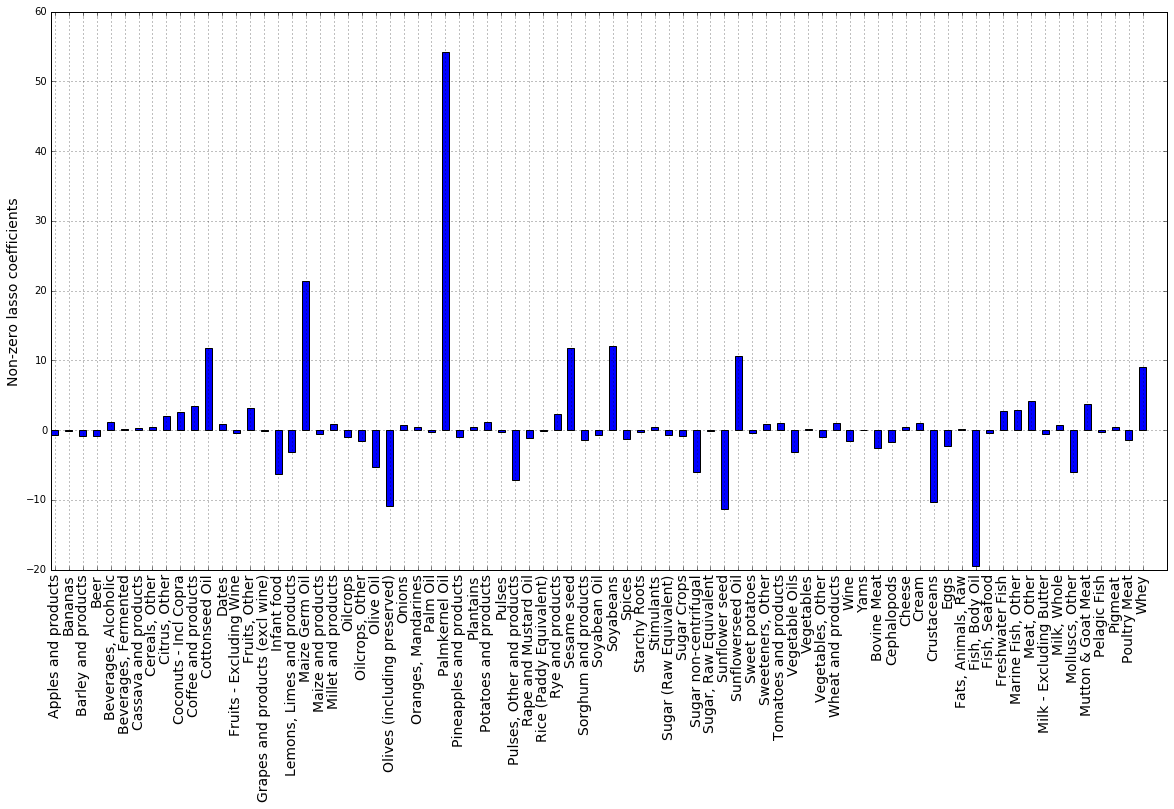

In [105]:
#Make bar chart of non zero coefficients
non_zero_coeffs2 = coefs2[np.nonzero(coefs2)]
non_zero_items = all_food_items_array[np.nonzero(coefs2)]
# print np.shape(non_zero_coeffs2)
# print np.shape(non_zero_items)
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

ind = np.arange(len(non_zero_coeffs2))  # the x locations for the groups
width = 0.5       # the width of the bars
ax.bar(ind, non_zero_coeffs2, width)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(non_zero_items)
labels = ax.get_xticklabels()
font_size = 14
plt.setp(labels, rotation=90, fontsize=font_size)
plt.ylabel('Non-zero lasso coefficients', fontsize=font_size)
ax.grid(True)
plt.show

It appears that various types of oils have some of the largest positive and negative associations with cardiovascular disease.  In particular, palmkernel oil has the largest positive coefficient, implying that consumption of this increases the chance of disease, while fish body oil has the largest negative coefficient, implying this food item decreases the change of disease.

# Future work
The lasso regression has a parameter which controls the penalty for number and magnitude of coefficients, and I intend to explore different values of this parameter.

I also plan to characterize world diets using principal components analysis, to see what the main world diets are by food type, and see if certain diets are connected with disease.